In [22]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image

# append path
sys.path.append('../')

# custom
from utils.BuildUNet import UNet
from utils.GetLowestGPU import GetLowestGPU
from utils.TileGenerator import TileGenerator
from utils.IOU import iou
from utils.AreaCalc import area_calc

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 03610MiB / 40537MiB
  1  | 03214MiB / 40537MiB
  2  | 04476MiB / 40537MiB
  3  | 00682MiB / 40537MiB
  4  | 00668MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:5
---------------------------


# Import Best Model Weights

In [9]:
# Load model
# instantiate model
model_kwargs = {
    'layer_sizes': [16, 32, 64, 128, 256],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None,
}

unet = UNet(**model_kwargs)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()


In [23]:
# find iteration with lowest loss
log_path = '../logs/'
log = pd.read_csv(log_path + 'log.csv')
best_loss = log.iloc[log["val_loss"].idxmin()]["iter_num"].astype(int)

In [24]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}.pt", map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]
# trained model has been loaded
unet.load_state_dict(weights)
unet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)
unet.to(device)

UNet(
  (hidden_activation): SELU()
  (enc_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU()
    (11): Dropout2d(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): SELU()
    

# Load Images

In [25]:
# load in images
# options
image_path = "../pennycress_pods/test/test_images/"
mask_path = "../pennycress_pods/test/test_masks/"
save_path = "../pennycress_pods/test/test_predictions/"

plot = True
verbose = True

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

# Create Predicted Segmentation Masks for Images

Processing 33.479-single.B.field 2023.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.936475470349158

Jaccard Distance (IoU) for envelope: 0.7446913262311162

Jaccard Distance (IoU) for seeds: 0.752927249409997

Processing 89.ISU386_B.B.ISU Wild.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.9289567359866521

Jaccard Distance (IoU) for envelope: 0.7432204479002666

Jaccard Distance (IoU) for seeds: 0.7672694535775795



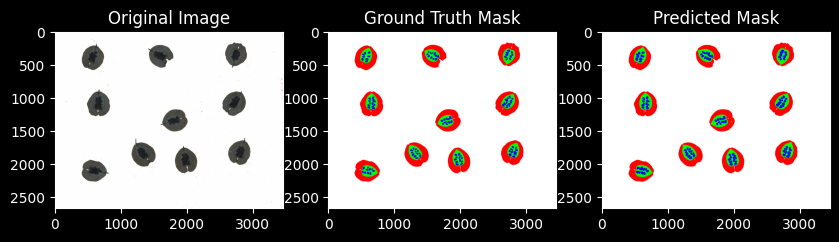

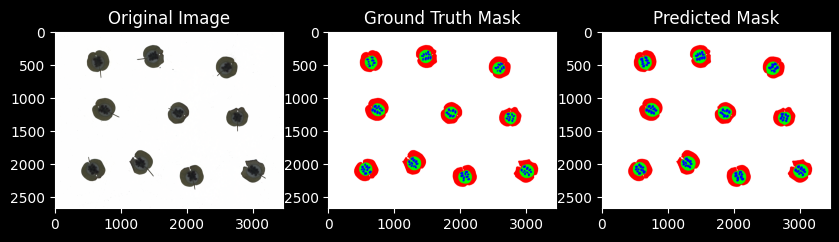

In [12]:
# create list to store predicted segmentations so that we can count seeds later
pred_images = []

# loop over images
for image_name in image_names:
    print(f"Processing {image_name}")

    # ----------------
    ## PREPROCESSING
    # ----------------

    # load in image and convert to a numpy array
    image = Image.open(image_path + image_name)
    image = np.array(image) / 255.0

    mask = np.array(Image.open(mask_path + image_name))[:,:,:3] / 255.0

    # fix weird mask behavior - all px. values are 0 or 1
    mask[mask > 0] = 1

    # pad first 2 dimensions, (H, W) by 32 px
    image = np.pad(image,
                pad_width= ((32, 32), (32, 32), (0, 0)),
                mode='edge')

    # ensure each image is divisible by 128 by adding extra padding

    rpad = 128 - image.shape[0] % 128
    cpad = 128 - image.shape[1] % 128

    # do we really need this? or can we optimize?
    image = np.pad(image,
                pad_width=((0, rpad), (0, cpad), (0, 0)),
                mode='edge')

    # initialize global prb. map with same spatial (H, W) dimensions as image and channel for each class
    global_prb_map = np.zeros((image.shape[0], image.shape[1], 4))

    ## BOOKKEEPING / PREDICTION

    # Double for loop over rows and columns with step size of 32 used for tile generation
    rows = range(0, image.shape[0]-(3*32), 32)
    cols = range(0, image.shape[1]-(3*32), 32)
    with tqdm(total=len(rows)*len(cols)) as pbar:
        for row in range(0, image.shape[0]-(3*32), 32): #don't index completely to the edge - otherwise, we will be indexing into a space that doesn't exist in the image
            for col in range(0, image.shape[1]-(3*32), 32):

                # select image tile
                tile = image[row:row+128, col:col+128]

                # make prediction and store the *center context* in global prb. map
                unet_input = torch.tensor(tile, dtype=torch.float32).to(device).permute(2, 0, 1).unsqueeze(0)
                prediction = unet(unet_input) 

                # softmax output
                prediction = torch.nn.functional.softmax(prediction, dim=1)

                # shuffle to be rows-cols-channels order and only take the center 64x64 square
                prediction = prediction[0].permute(1, 2, 0)[32:-32, 32:-32, :]

                # add predicted probabilities to prb map at index
                global_prb_map[row+32:row+96, col+32:col+96, :] += prediction.detach().cpu().numpy()
                pbar.update(1)

    # now that we have full prb. map, remove the padding 
    global_prb_map = global_prb_map[32:-(32+rpad), 32:-(32+cpad), :]
    image = image[32:-(32+rpad), 32:-(32+cpad), :]

    # and normalize prbs. s.t they sum to one
    global_prb_map = global_prb_map / global_prb_map.sum(axis=-1, keepdims=True)

    # convert predicted probabilities to predicted classes and retain four channels
    argmaxes = np.argmax(global_prb_map, axis=2)
    preds = np.zeros(global_prb_map.shape)
    for i in range(4):
        preds[:, :, i] = (argmaxes == i)

    # remove bg channel
    pred_image = preds[:, :, 1:]

    # ---------------
    # IOU
    # ---------------

    wing_gt = mask[:, :, 0] == 1
    wing_pred = pred_image[:, :, 0] == 1
    wing_iou = iou(wing_gt, wing_pred)

    env_gt = mask[:, :, 1] == 1 
    env_pred = pred_image[:, :, 1] == 1  
    env_iou = iou(env_gt, env_pred)

    seed_gt = mask[:, :, 2] == 1
    seed_pred = pred_image[:, :, 2] == 1
    seed_iou = iou(seed_gt, seed_pred)

    if verbose:
        print(f"Jaccard Distance (IoU) for wing: {wing_iou}\n")
        print(f"Jaccard Distance (IoU) for envelope: {env_iou}\n")
        print(f"Jaccard Distance (IoU) for seeds: {seed_iou}\n")

    # ----------------
    ## ARTFACT REMOVAL
    # ----------------

    # set bg to white
    pred_image[pred_image.sum(axis=2) == 0] = 1
    mask[mask.sum(axis=2) == 0] = 1

    # create binary mask
    pred_mask = pred_image.sum(axis=2) != 3

    # remove small artifacts
    size = 500
    labels = ndimage.label(pred_mask)[0]
    sizes = np.bincount(labels.reshape(-1))
    for j in range(1, len(sizes)):
        if sizes[j] < size:
            pred_mask[labels == j] = False

    pred_mask = cv2.cvtColor(pred_mask.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    pred_image[pred_mask.sum(2) == 0] = 1

    # ----------------
    ## PLOTTING
    # ----------------
    
    if plot:
        # plot the image and prediction together
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")

        # set mask bg to white and overlay on image
        ax[1].imshow(mask)
        ax[1].set_title("Ground Truth Mask")

        ax[2].imshow(pred_image)
        ax[2].set_title("Predicted Mask")
        plt.show

    # append to pred images list for counting
    pred_images.append(pred_image)

    # save the predicted mask
    pred_image = Image.fromarray((pred_image * 255).astype(np.uint8))
    pred_image.save(save_path + "pred_" + image_name)

# Seed Counting

In [26]:
## OPTIONS
pred_path = "../pennycress_pods/test/test_predictions/"
pod_save_path = "../pennycress_pods/test/test_predictions_by_pod/"
measurement_save_path = "../pennycress_pods/test/test_measurements/"

pred_image_names = glob.glob(pred_path + "*.png")
pred_image_names = [os.path.basename(x) for x in pred_image_names]

wing area: 34.41 cm | env area: 13.91 cm | seed area: 8.39 cm
seed count: 8


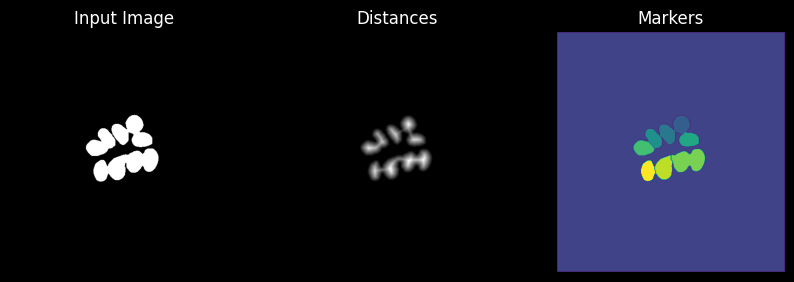

wing area: 36.51 cm | env area: 14.06 cm | seed area: 7.80 cm
seed count: 8


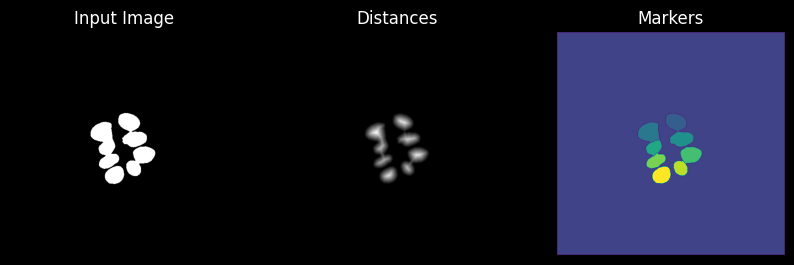

wing area: 33.87 cm | env area: 13.62 cm | seed area: 7.61 cm
seed count: 8


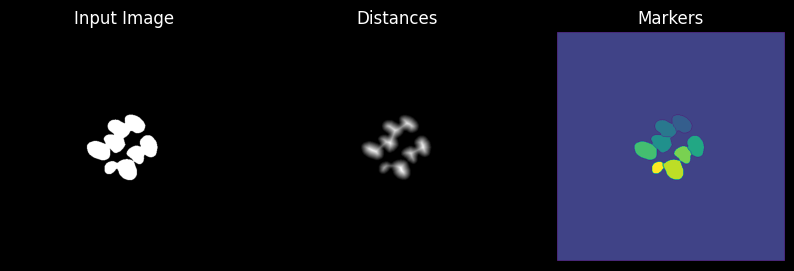

wing area: 37.65 cm | env area: 14.66 cm | seed area: 8.68 cm
seed count: 9


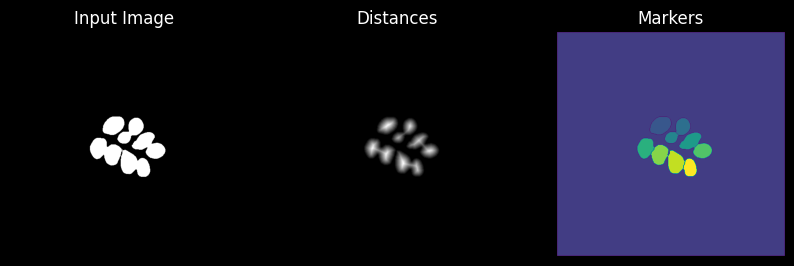

wing area: 30.21 cm | env area: 14.26 cm | seed area: 7.44 cm
seed count: 7


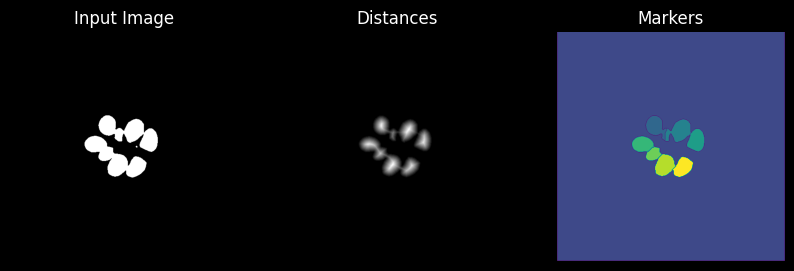

wing area: 30.65 cm | env area: 12.53 cm | seed area: 7.18 cm
seed count: 9


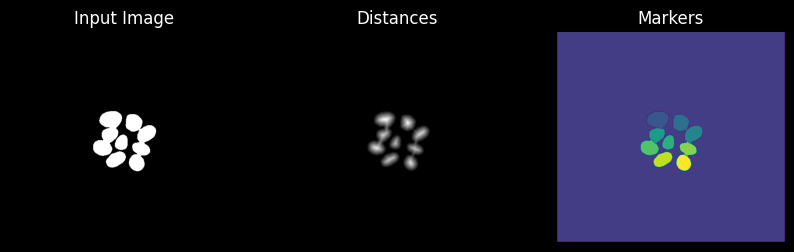

wing area: 34.00 cm | env area: 16.54 cm | seed area: 8.44 cm
seed count: 8


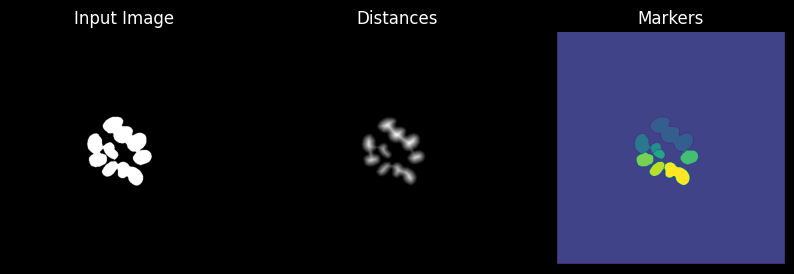

wing area: 37.02 cm | env area: 14.35 cm | seed area: 8.70 cm
seed count: 10


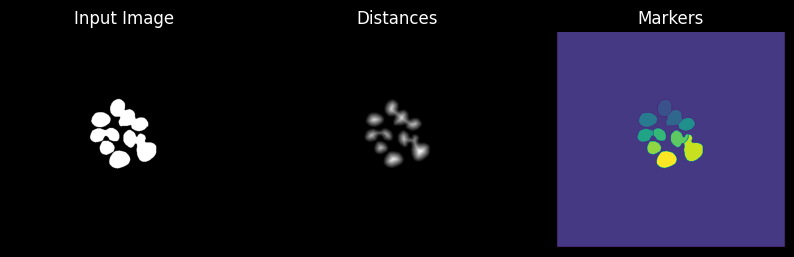

wing area: 34.46 cm | env area: 16.46 cm | seed area: 8.97 cm
seed count: 8


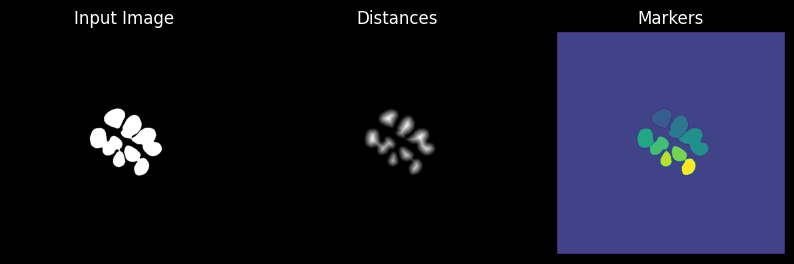

wing area: 37.19 cm | env area: 15.44 cm | seed area: 8.43 cm
seed count: 8


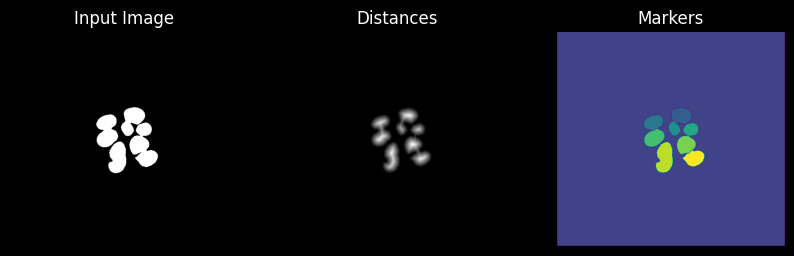

wing area: 26.47 cm | env area: 12.76 cm | seed area: 6.28 cm
seed count: 7


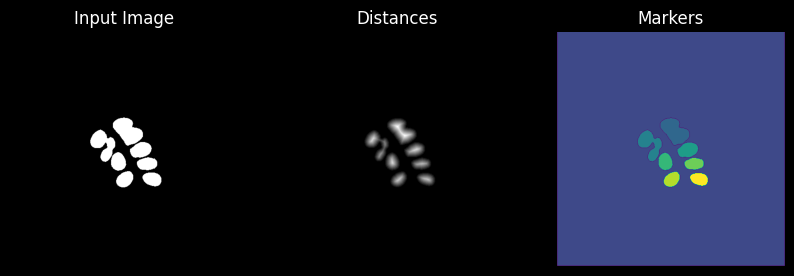

wing area: 25.99 cm | env area: 12.30 cm | seed area: 5.53 cm
seed count: 9


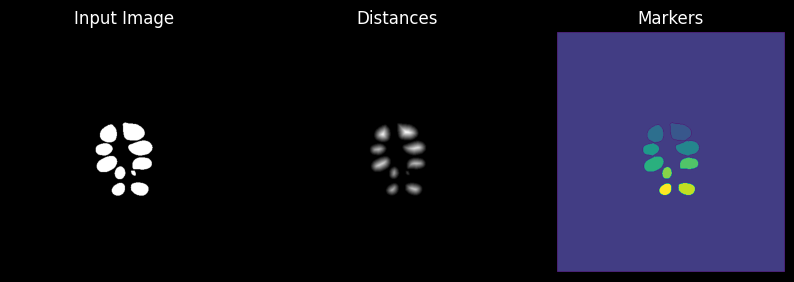

wing area: 27.68 cm | env area: 14.06 cm | seed area: 5.81 cm
seed count: 10


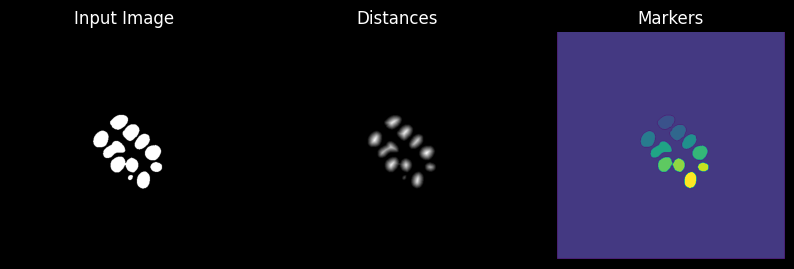

wing area: 29.93 cm | env area: 13.21 cm | seed area: 6.50 cm
seed count: 10


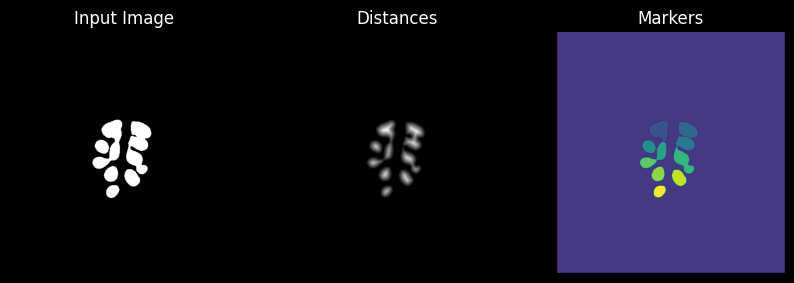

wing area: 27.83 cm | env area: 13.39 cm | seed area: 5.82 cm
seed count: 8


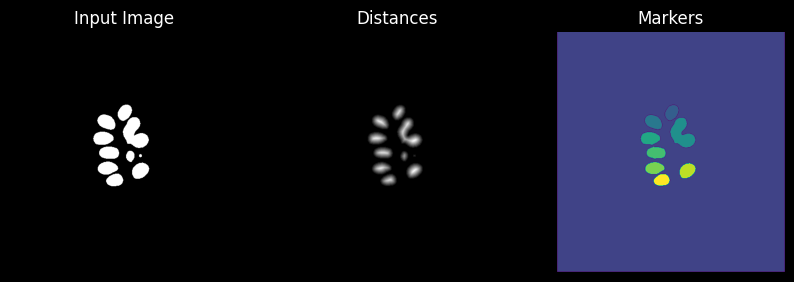

wing area: 22.76 cm | env area: 9.94 cm | seed area: 4.48 cm
seed count: 7


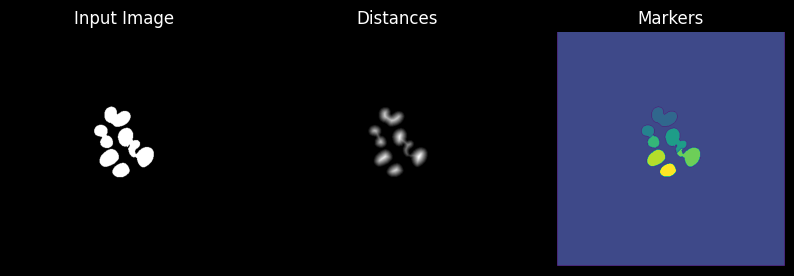

wing area: 29.07 cm | env area: 14.40 cm | seed area: 5.90 cm
seed count: 11


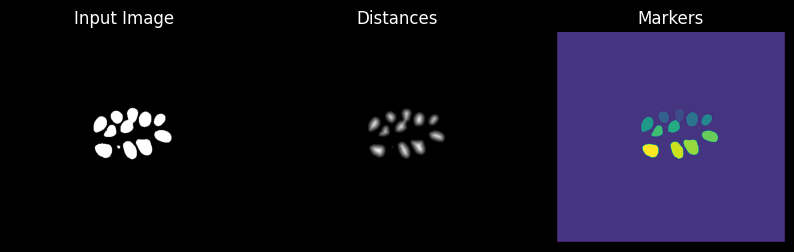

wing area: 29.68 cm | env area: 13.12 cm | seed area: 6.14 cm
seed count: 10


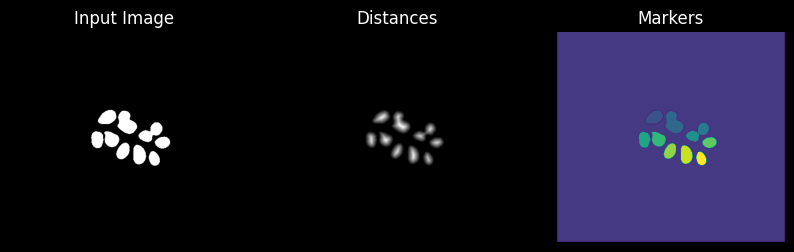

wing area: 31.03 cm | env area: 14.50 cm | seed area: 6.72 cm
seed count: 12


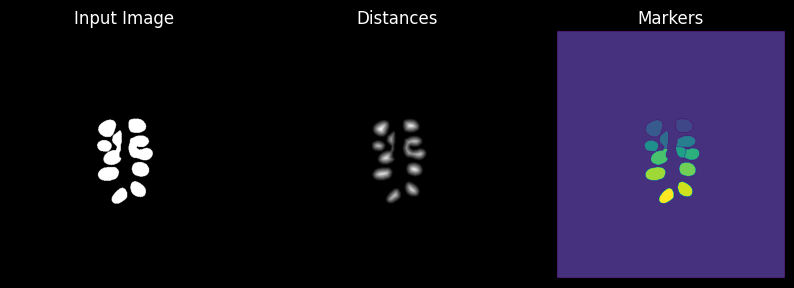

wing area: 25.41 cm | env area: 13.08 cm | seed area: 5.23 cm
seed count: 9


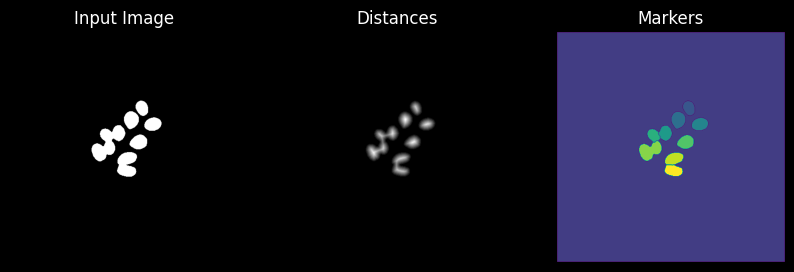

wing area: 28.93 cm | env area: 9.32 cm | seed area: 4.06 cm
seed count: 8


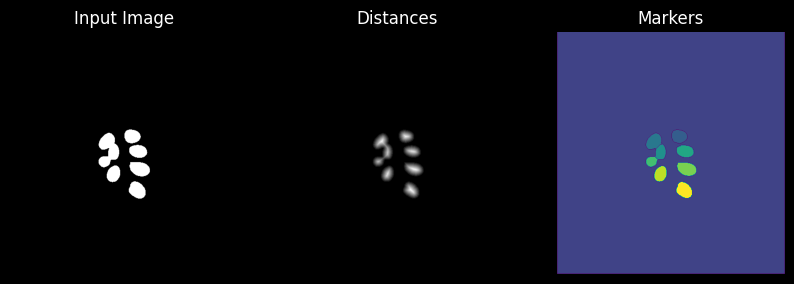

wing area: 30.18 cm | env area: 10.85 cm | seed area: 4.35 cm
seed count: 10


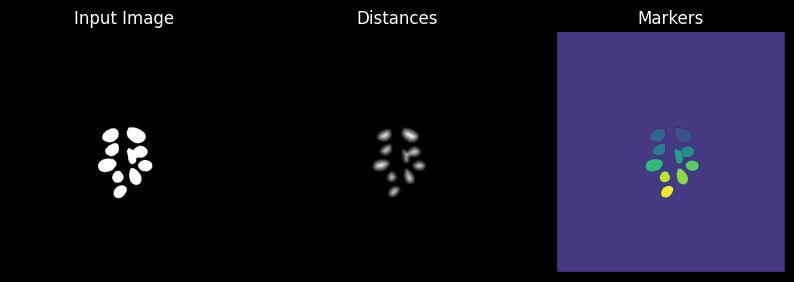

wing area: 28.81 cm | env area: 9.32 cm | seed area: 4.03 cm
seed count: 10


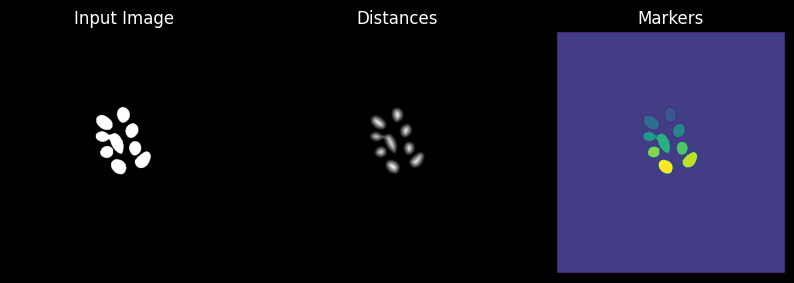

wing area: 30.84 cm | env area: 10.52 cm | seed area: 5.26 cm
seed count: 9


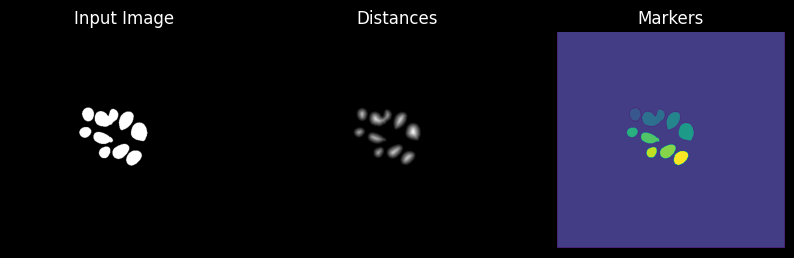

wing area: 32.22 cm | env area: 11.12 cm | seed area: 4.33 cm
seed count: 10


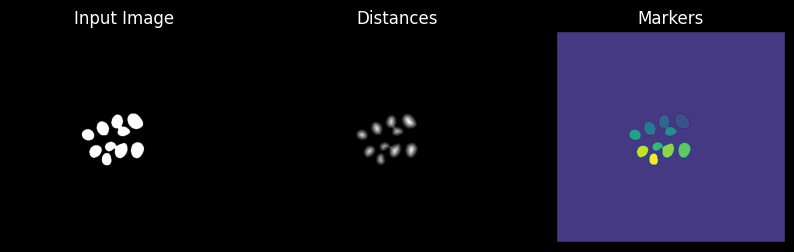

wing area: 33.78 cm | env area: 12.58 cm | seed area: 4.61 cm
seed count: 9


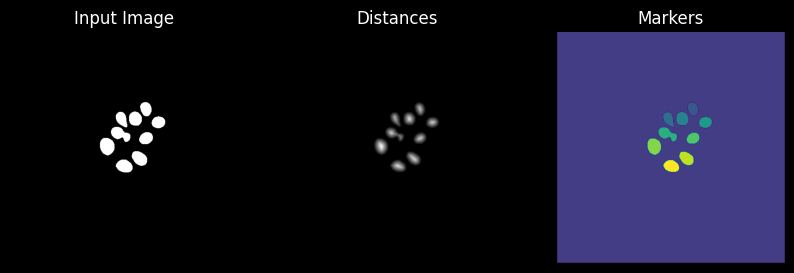

wing area: 28.00 cm | env area: 9.99 cm | seed area: 3.95 cm
seed count: 9


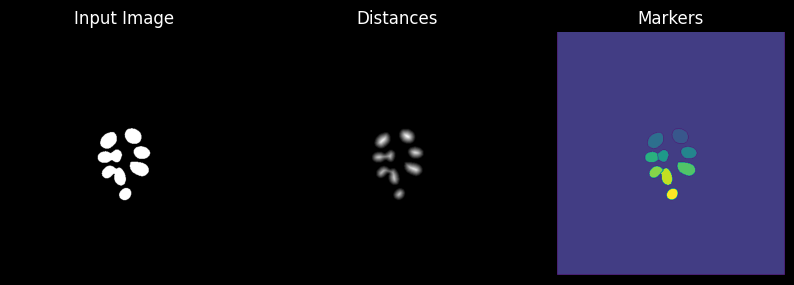

wing area: 29.40 cm | env area: 10.83 cm | seed area: 3.53 cm
seed count: 8


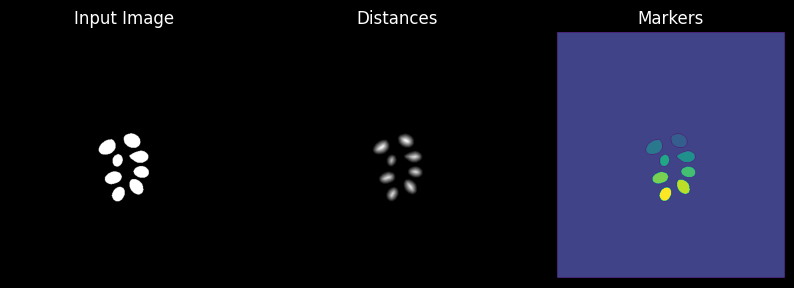

wing area: 32.69 cm | env area: 10.94 cm | seed area: 4.62 cm
seed count: 10


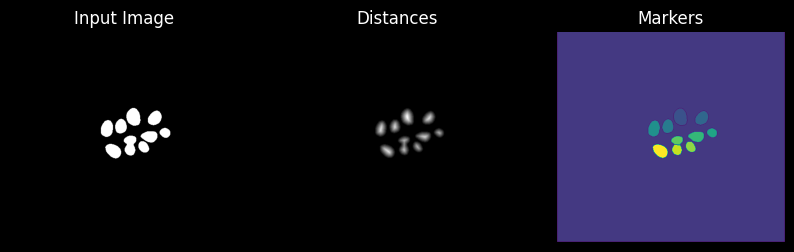

wing area: 28.54 cm | env area: 9.73 cm | seed area: 3.50 cm
seed count: 8


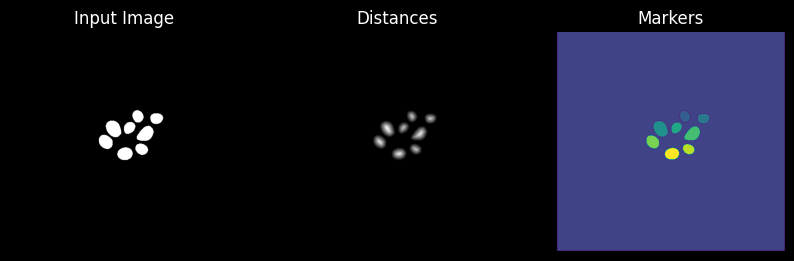

wing area: 35.84 cm | env area: 15.84 cm | seed area: 7.48 cm
seed count: 8


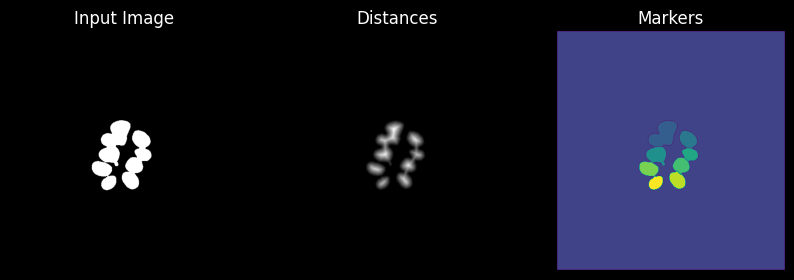

wing area: 36.38 cm | env area: 15.31 cm | seed area: 8.37 cm
seed count: 10


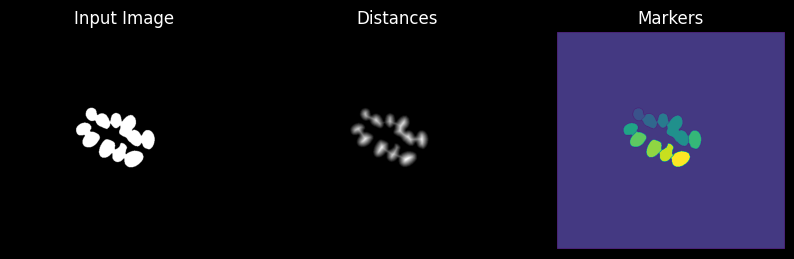

wing area: 39.94 cm | env area: 14.71 cm | seed area: 7.58 cm
seed count: 7


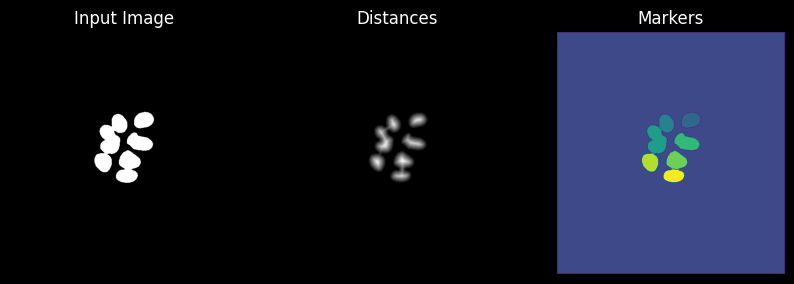

wing area: 41.09 cm | env area: 16.92 cm | seed area: 8.40 cm
seed count: 10


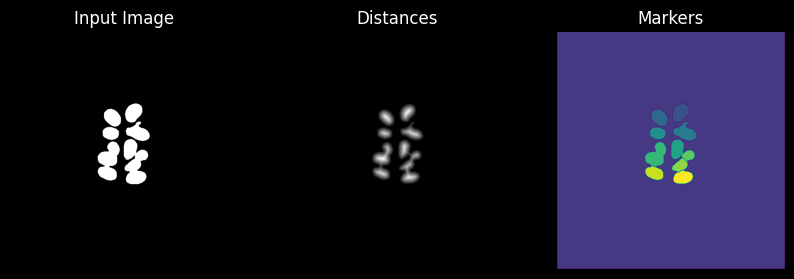

wing area: 40.57 cm | env area: 15.14 cm | seed area: 9.16 cm
seed count: 9


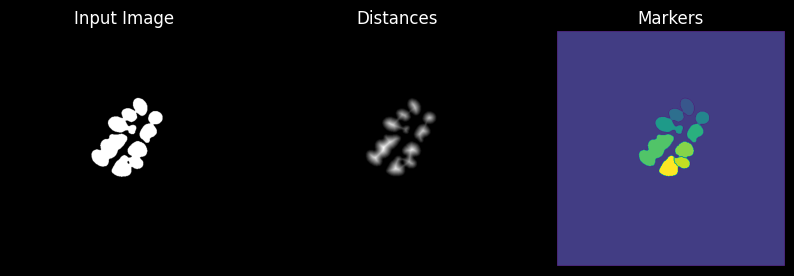

wing area: 40.23 cm | env area: 16.42 cm | seed area: 7.46 cm
seed count: 11


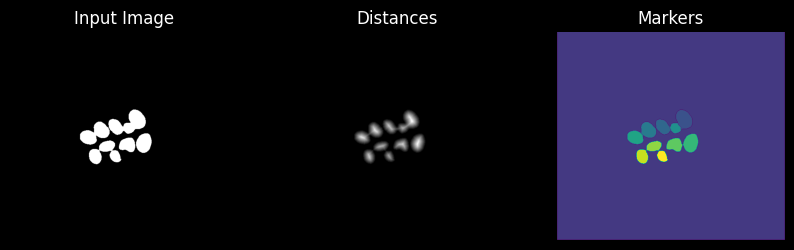

wing area: 39.95 cm | env area: 14.33 cm | seed area: 8.66 cm
seed count: 10


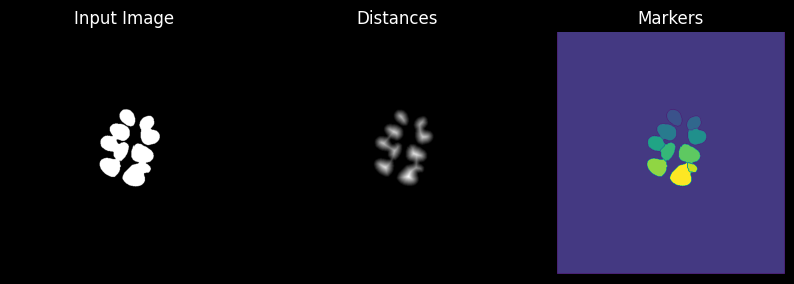

wing area: 42.25 cm | env area: 15.51 cm | seed area: 8.93 cm
seed count: 12


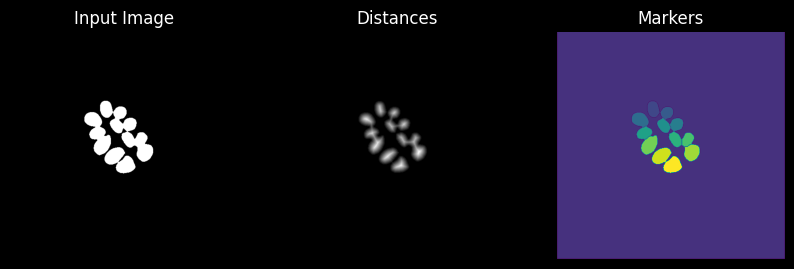

wing area: 40.98 cm | env area: 15.01 cm | seed area: 9.64 cm
seed count: 10


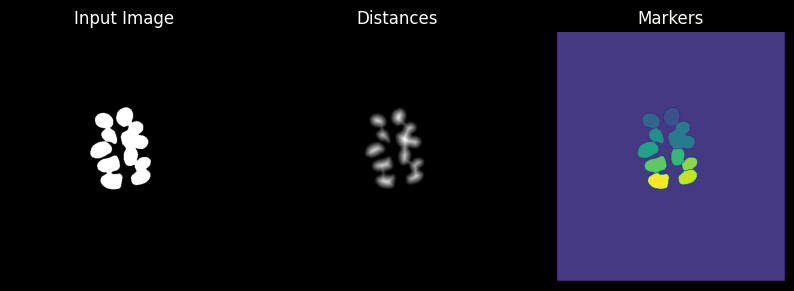

wing area: 39.24 cm | env area: 15.23 cm | seed area: 8.26 cm
seed count: 8


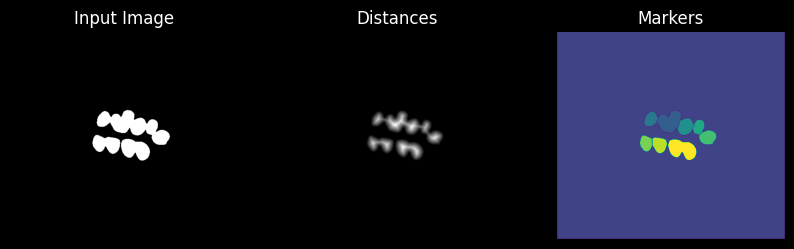

wing area: 35.54 cm | env area: 13.08 cm | seed area: 3.58 cm
seed count: 7


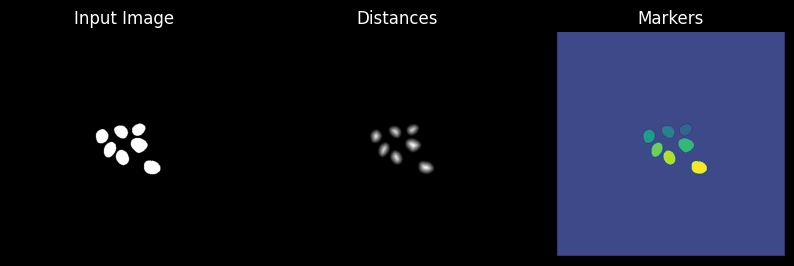

wing area: 40.00 cm | env area: 12.27 cm | seed area: 4.78 cm
seed count: 8


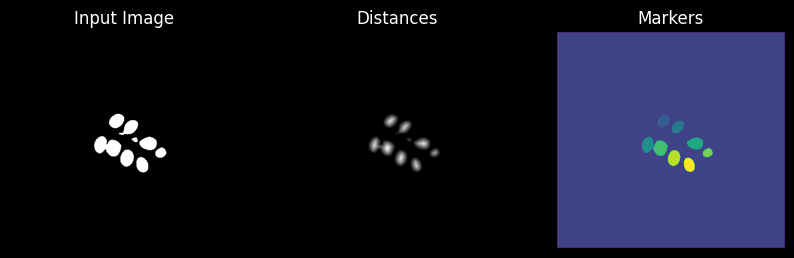

wing area: 37.47 cm | env area: 12.06 cm | seed area: 4.57 cm
seed count: 8


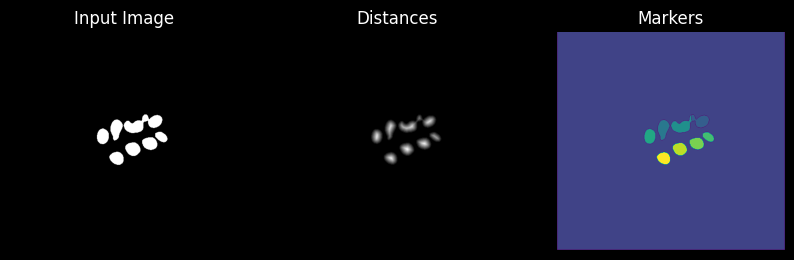

wing area: 36.87 cm | env area: 13.54 cm | seed area: 3.78 cm
seed count: 7


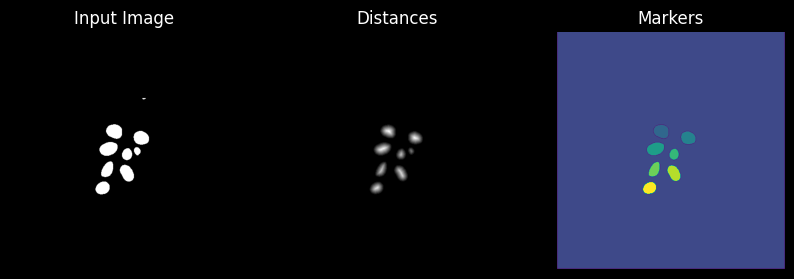

wing area: 37.17 cm | env area: 13.02 cm | seed area: 4.60 cm
seed count: 8


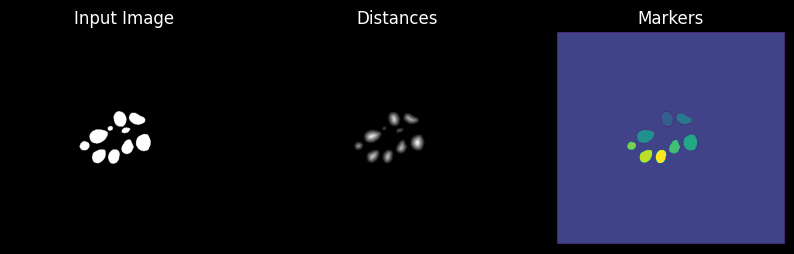

wing area: 33.69 cm | env area: 12.44 cm | seed area: 3.98 cm
seed count: 8


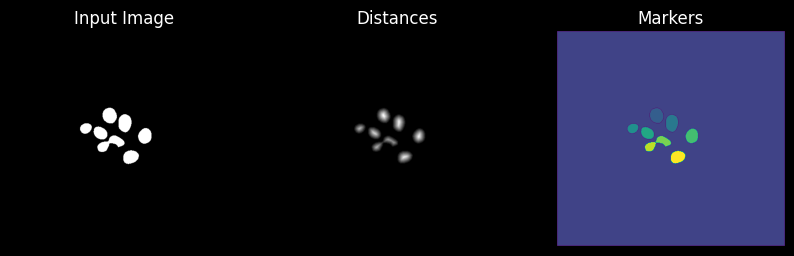

wing area: 28.00 cm | env area: 11.08 cm | seed area: 3.71 cm
seed count: 8


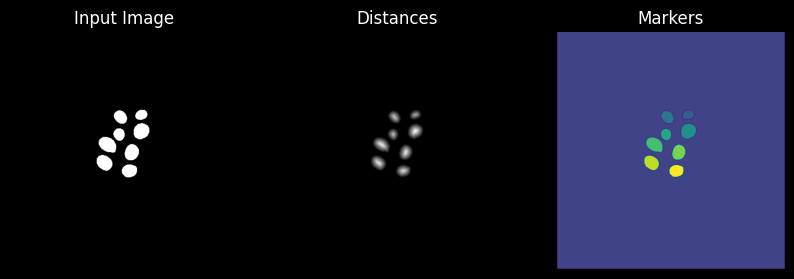

wing area: 40.81 cm | env area: 13.59 cm | seed area: 5.21 cm
seed count: 10


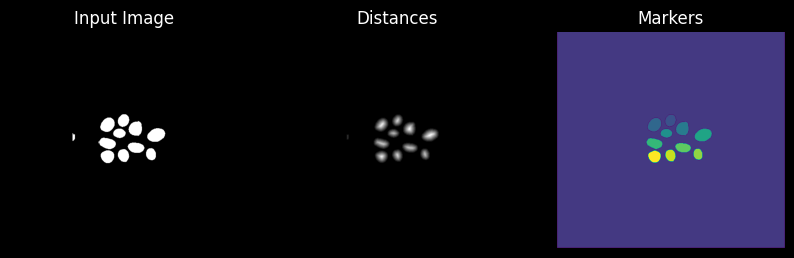

wing area: 37.98 cm | env area: 13.42 cm | seed area: 4.86 cm
seed count: 11


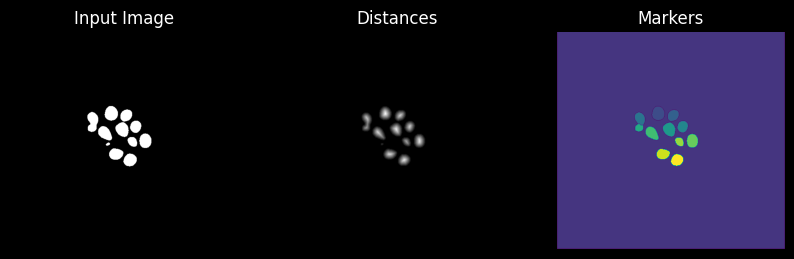

wing area: 34.17 cm | env area: 12.27 cm | seed area: 4.81 cm
seed count: 8


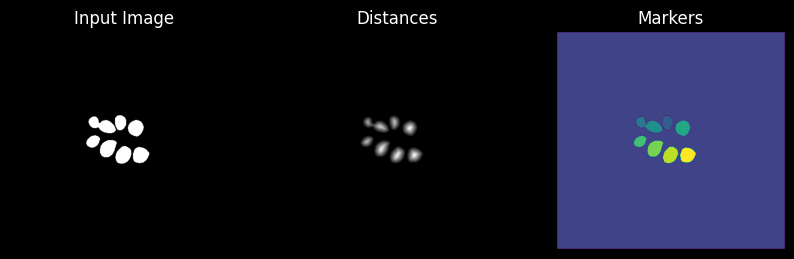

Avg. Seed Count: 8.90 seeds Avg. Wing Area: 33.67 cm Avg. Envelope Area: 13.26 cm Avg. Seed Area: 6.20 cm


In [30]:
# Seed Counting

plot = True
verbose = True

# create list to store seed counts and area
measurements = []

for pred_image_name in pred_image_names:

        ## PREPROCESSING

        # for a single image:
        pred_image = Image.open(pred_path + pred_image_name)
        pred_image = np.array(pred_image) / 255 
        
        # revert white background to black
        pred_image[pred_image.sum(axis=2) == 3] = 0

        # pad image so that we can draw bounding box around it
        pred_image = np.pad(pred_image, ((100, 100), (100, 100), (0, 0)), mode='constant')

        # extract bool mask for object detection
        bool_mask = np.array(pred_image).sum(axis=2) > .5 # convert to boolean mask

        # label each object in the image and draw bounding box around it
        labels = ndimage.label(bool_mask)[0]
        bboxes = ndimage.find_objects(labels)

        # add padding to bounding boxes
        x_pad, y_pad = 100, 100
        for i in range(len(bboxes)):
                x, y = bboxes[i]
                bboxes[i] = slice(x.start-x_pad, x.stop+x_pad), slice(y.start-y_pad, y.stop+y_pad)

        ## WATERSHEDDING / AREA CALC

        # loop through split images
        for i, bbox in enumerate(bboxes):
                y, x = bbox
                split_image = pred_image[y, x, :]

                # calculate area
                wing_area = area_calc(split_image[:, :, 0])
                env_area = area_calc(split_image[:, :, 1])
                seed_area = area_calc(split_image[:, :, 2])
                
                if verbose:
                        print(f"wing area: {wing_area:.2f} cm", "|", f"env area: {env_area:.2f} cm", "|", f"seed area: {seed_area:.2f} cm")

                # extract only the blue channel (seeds) from the image
                image = split_image[:, :, 2].astype(np.int64)

                # change image type and make 3-channel mask
                image = image.astype(np.uint8) * 255

                # define kernel for operations
                kernel = np.ones((3,3),np.uint8)

                # # erode image to define splits
                # image = cv2.erode(image, kernel, iterations=2)

                rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                # noise removal
                opening = cv2.morphologyEx(image,
                                           cv2.MORPH_OPEN,kernel,
                                           iterations = 2)
                
                # sure background area
                sure_bg = cv2.dilate(opening,
                                     kernel,
                                     iterations=3)
                
                # Finding sure foreground area
                dist_transform = cv2.distanceTransform(opening,
                                                       cv2.DIST_L2,
                                                       5)
                ret, sure_fg = cv2.threshold(dist_transform,
                                             0.6*dist_transform.max(),
                                             255,
                                             0)
                
                # Finding unknown region
                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg,sure_fg)

                # Marker labelling
                ret, markers = cv2.connectedComponents(sure_fg)

                # Add one to all labels so that sure background is not 0, but 1
                markers = markers+1
                
                # Now, mark the region of unknown with zero
                markers[unknown==255] = 0

                #plot markers
                markers_to_plot = markers

                rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

                markers = cv2.watershed(rgb, markers)
                rgb[markers == -1] = [255,0,0]

                # count seeds
                seed_count = len(np.unique(markers)) - 2
                print("seed count:", seed_count)

                if plot:
                        ## PLOTTING

                        # plot fg, bg, unknown, distances, markers, and labeled output
                        fix, ax = plt.subplots(1, 3, figsize=(10, 5))

                        ax[0].imshow(image, cmap="gray")
                        ax[0].set_title("Input Image")

                        ax[1].imshow(dist_transform, cmap="gray")
                        ax[1].set_title("Distances")

                        ax[2].imshow(markers_to_plot)
                        ax[2].set_title("Markers")

                
                        for axis in ax:
                                axis.set_axis_off()
                        plt.tight_layout
                        plt.show()

                ## BOOKKEEPING
                
                # save split predicted image
                save_name = pred_image_name[:-4] + "_" + str(i) + ".png"
                split_image = Image.fromarray((split_image * 255).astype(np.uint8))
                split_image.save(pod_save_path + save_name)

                # save seed count
                measurements.append((save_name, seed_count, wing_area, env_area, seed_area))

# save seed counts to csv
measurements = pd.DataFrame(measurements, columns=["image_name", "seed_count", "wing area", "env area", "seed area"])

if verbose:

        avg_seed_count = measurements["seed_count"].mean()
        avg_wing = measurements["wing area"].mean()
        avg_env = measurements["env area"].mean()
        avg_seed = measurements["seed area"].mean()

        print(f"Avg. Seed Count: {avg_seed_count:.2f} seeds",
              f"Avg. Wing Area: {avg_wing:.2f} cm",
              f"Avg. Envelope Area: {avg_env:.2f} cm",
              f"Avg. Seed Area: {avg_seed:.2f} cm")
        
measurements.to_csv(measurement_save_path + "seed_counts.csv", index=False)
